<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

# GeoClaw Storm Surge Modeling:  Updates and New Features

## Thank You to Contributors

## Storm Object

> This object contains a time series of time data that describe a particular
    storm.  This includes the attributes below and the ability to read from
    multiple sources for data such as the U.S. National Hurricane Center (NHC),
    the Japanese Meterological Agency (JMA), and the Indian Meteorlogical
    Department (IMD).  This class can then write out in any of these formats,
    construct the wind and pressure fields using a supported parameterized
    model, or output the GeoClaw supported storm format used for running storm
    surge simulations.

**Important Point** - Python data container for time series description of a storm

### Core Capabilities

 - `read` in lots of storm formats (e.g. *ATCF*, *HURDAT*, *JMA*)

 - `write` out in some storm formats (e.g. *GeoClaw*, *ATCF*, *HURDAT*)

 - `plot` storm track and intensity

 - `category` of storm given a categorization scheme

### Utilities

 - `construct_fields` of a storm given a parameterization (e.g. Holland 1980, CLE 2015)
 - Others

### Example Use
```python
# Storm parameters - Parameterized storm (Holland 1980)
data.storm_specification_type = 'holland80'  # (type 1)
data.storm_file = os.path.expandvars(os.path.join(os.getcwd(), 'ike.storm'))
```

```python
# Convert ATCF data to GeoClaw format
clawutil.data.get_remote_file(
               "http://ftp.nhc.noaa.gov/atcf/archive/2008/bal092008.dat.gz")
atcf_path = os.path.join(scratch_dir, "bal092008.dat")
# Note that the get_remote_file function does not support gzip files which
# are not also tar files.  The following code handles this
with gzip.open(".".join((atcf_path, 'gz')), 'rb') as atcf_file,    \
        open(atcf_path, 'w') as atcf_unzipped_file:
    atcf_unzipped_file.write(atcf_file.read().decode('ascii'))
```

```python
# Read in unzipped file
ike = Storm(path=atcf_path, file_format="ATCF")
```

```python
# Calculate landfall time - Need to specify as the file above does not
# include this info (9/13/2008 ~ 7 UTC)
ike.time_offset = datetime.datetime(2008, 9, 13, 7)
```

```python
# Write storm data to GeoClaw format
ike.write(data.storm_file, file_format='geoclaw')
```

**GeoClaw Storm Format**
```bash
53
2008-09-13T07:00:00

    -1.04040000e+06     -3.70000000e+01      1.72000000e+01      1.54333332e+01      1.66680000e+05      1.00600000e+05      4.63000000e+05
    -1.01880000e+06     -3.84000000e+01      1.73000000e+01      1.80055554e+01      1.66680000e+05      1.00500000e+05      4.63000000e+05
    -9.97200000e+05     -3.99000000e+01      1.75000000e+01      2.31499998e+01      1.66680000e+05      1.00300000e+05      4.63000000e+05
    -9.75600000e+05     -4.13000000e+01      1.78000000e+01      2.31499998e+01      3.70400000e+04      1.00200000e+05      4.63000000e+05
    -9.54000000e+05     -4.28000000e+01      1.82000000e+01      2.31499998e+01      3.70400000e+04      1.00000000e+05      5.09300000e+05
    -9.32400000e+05     -4.43000000e+01      1.87000000e+01      2.57222220e+01      1.66680000e+05      9.99000000e+04      4.63000000e+05
...
```

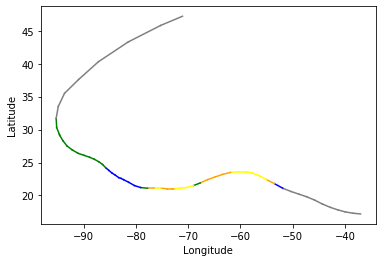

In [1]:
import os
import gzip
import datetime

import matplotlib.pyplot as plt

from clawpack.geoclaw.surge.storm import Storm
import clawpack.clawutil as clawutil

# Scratch directory for storing topo and dtopo files:
scratch_dir = os.path.join(os.environ["CLAW"], 'geoclaw', 'scratch')

# Convert ATCF data to GeoClaw format
clawutil.data.get_remote_file("http://ftp.nhc.noaa.gov/atcf/archive/2008/bal092008.dat.gz")
atcf_path = os.path.join(scratch_dir, "bal092008.dat")
# Note that the get_remote_file function does not support gzip files which
# are not also tar files.  The following code handles this
with gzip.open(".".join((atcf_path, 'gz')), 'rb') as atcf_file,    \
        open(atcf_path, 'w') as atcf_unzipped_file:
    atcf_unzipped_file.write(atcf_file.read().decode('ascii'))

# Uncomment/comment out to use the old version of the Ike storm file
# ike = Storm(path="old_ike.storm", file_format="ATCF")
ike = Storm(path=atcf_path, file_format="ATCF")

# Calculate landfall time - Need to specify as the file above does not
# include this info (9/13/2008 ~ 7 UTC)
ike.time_offset = datetime.datetime(2008, 9, 13, 7)

# Plot
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
ike.plot(axes=axes, intensity=True)
plt.show()

## Paramaterized Wind Models

**Parameterizations:** Holland 1980, Holland 2010, CLE, SLOSH, Rankine, Modified Rankine, deMaria, Willoughby

Added to both the Python and Fortran code.

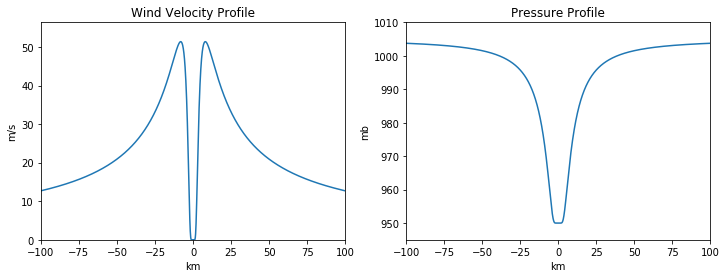

In [2]:
import numpy
import matplotlib.pyplot as plt

# Parameters
N = 1000
radius = 100e3
Pn = 1005
Pc = 950
A = 23.0
B = 1.5
rho_air = 1.15
OMEGA = 7.2722052166430395e-5
THETA_0 = 0.52359877559829882 
f = 2.0 * OMEGA * numpy.sin(THETA_0)
f = 0.0

# Evaluate profiles
x = numpy.concatenate((numpy.linspace(-radius, -0.01, N), 
                       numpy.linspace(0.01, radius, N)), axis=0)
r = numpy.abs(x) * 1e-3
p = Pc + (Pn - Pc) * numpy.exp(-A/(r)**B)
C = 1e1**2 *A * B * (Pn - Pc) / (rho_air)
v = numpy.sqrt(C * numpy.exp(-A / r**B) / r**B + r**2 * f**2 / 4.0) - r * f / 2.0

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)

# Convert to kms
x /= 1e3

axes = fig.add_subplot(1, 2, 1)
axes.plot(x, v)
axes.set_title("Wind Velocity Profile")
axes.set_xlabel('km')
axes.set_ylabel('m/s')
axes.set_xlim([numpy.min(x), numpy.max(x)])
axes.set_ylim([0.0, numpy.max(v) + 5])

axes = fig.add_subplot(1, 2, 2)
axes.plot(x, p)
axes.set_title("Pressure Profile")
axes.set_xlabel('km')
axes.set_ylabel('mb')
axes.set_xlim([numpy.min(x), numpy.max(x)])
axes.set_ylim([Pc - 5, Pn + 5])

plt.show()

## Examples Added

 - Synthetic basin example
 - [Storm Surge Tutorial](https://github.com/clawpack/apps/tree/master/notebooks/geoclaw/katrina)(https://github.com/clawpack/apps/tree/master/notebooks/geoclaw/katrina)
 - [Full Examples](https://github.com/mandli/surge-examples) (https://github.com/mandli/surge-examples)- Please Contribute!

## Ensembles of Storms

Create and manage an [ensemble of storms](https://github.com/mandli/batch/).

https://github.com/mandli/batch/

## Bugs Squashed

 - Recording storm fields at gauges